# MetroloPy

tools for dealing with physical quantities:  uncertainty propagation and unit conversion

---

## Table of Contents

* [getting started](#getting-started)
* [tutorial](#tutorial)
    * [expressing physical quantities](#expressing-physical-quantities)
    * [propagating uncertainty](#propagating-uncertainty)
    * [Monte-Carlo uncertainty propagation](#Monte-Carlo-uncertainty-propagation)
    * [expanded uncertainty](#expanded-uncertainty)
    * [an uncertainty budget](#an-uncertainty-budget)
    * [degrees of freedom and uncertainty types](#degrees-of-freedom-and-uncertainty-types)
    * [units and mathematical operations](#units-and-mathematical-operations)
    * [built-in and user defined units](#built-in-and-user-defined-units)
    * [applying numerical functions to gummys](#applying-numerical-functions-to-gummys)
    * [curve fitting](#curve-fitting)
    * [creating correlated gummys](#creating-correlated-gummys)
    * [formatting](#formatting)
    * [floating point rounding errors](#floating-point-rounding-errors)

## getting started

MetroloPy is a pure python package and requires Python 3 and the [SciPy stack](https://www.scipy.org/) (NumPy, SciPy, Pandas, and IPython).  It looks best in a [Jupyter Notebook](https://jupyter.org/) like the one used to create this tutorial.

Install MetroloPy with pip:

```
$ pip install metrolopy
```

See the [MetroloPy home page](http://nrc-cnrc.github.io/MetroloPy/) for the full documentation.

---


## tutorial


### expressing physical quantities
A gummy object represents a physical quantity with an uncertainty and (or) a unit:

In [1]:
import metrolopy as uc

In [2]:
side_a = uc.gummy(1.2345,u=0.0234,unit='cm')
side_a

1.234(23) cm

By default concise notation is used when a gummy is printed, where the numbers in parentheses represent the uncertainty in the last digits of the value. There are many other ways that the uncertainty can be notated, for example:

In [3]:
side_a.style='+-'
side_a

(1.234 ± 0.023) cm

or:

In [4]:
side_a.uunit = 'um' # the uunit property sets the units on the uncertainty
side_a

1.234 cm ± 234 μm

or:

In [5]:
side_a.uunit = '%'
side_a

1.234 cm ± 1.9%

### propagating uncertainty

Gummys can be used in arbitrary formulas, propagating the uncertainties:

In [6]:
side_b = uc.gummy(3.034,u=0.174,unit='mm')
side_b

3.03(17) mm

In [7]:
angle = uc.arctan(side_b/side_a)
angle

0.241(14)

In [8]:
angle.convert('degree')

13.81(80)°

Or another example:

In [9]:
area = side_a*side_b
area

0.375(23) cm²

The gummys keep track of any correlations between values:

In [10]:
area.correlation(angle)

0.80303611233768657

Up to now we have assumed that the uncertainties are best modeled with a Normal probability distribution, but we can define a gummy with, say, a uniform probability distribution:

In [11]:
force = uc.gummy(uc.UniformDist(center=0.9345,half_width=0.096),unit='N')
force

0.934(55) N

And we can calculate:

In [12]:
pressure = force/area
pressure

2.50(21) N/cm²

In [13]:
pressure.unit = 'kPa'
pressure

25.0(21) kPa

### Monte-Carlo uncertainty propagation

Above, gummy just took the standard deviation of the force probability distribution and then forgot about the shape and propagated the uncertainties assuming everything was Gaussian.  However we can also do a Monte-Carlo simulation using the actual probability distributions:

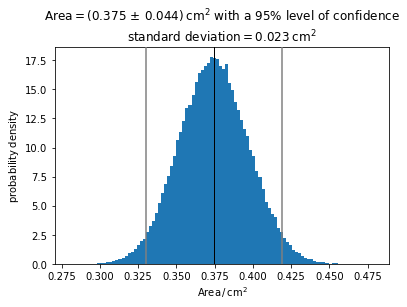

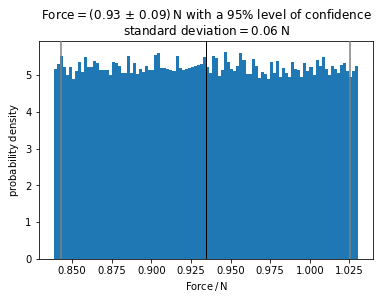

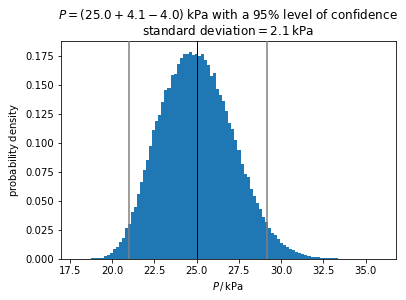

In [14]:
uc.gummy.simulate([area,force,pressure])  # generate Monte-Carlo data, default is 1e6 samples for each gummy

area.name = 'Area'  #give the variables names for the plot
area.p = 0.95  # put the reference lines in the histograms at a 95% confidence interval
area.hist()  # create the histogram for a (we could have used a.hist(p=0.95) instead of a.p = 0.95 above)

force.name = 'Force'
force.p = 0.95
force.cimethod = 'symmetric'  # The default method for calculating confidence intervals is 
                          # cimethod = 'shortest', the shortest interval with the desired 
                          # confidence level.  But this doesn't work well with a uniform distribution.
force.hist()

pressure.name = 'Pressure'
pressure.p = 0.95
pressure.name = 'P'
pressure.hist()

### expanded uncertainty

When we did the first uncertainty propagation for pressure we just got the standard (1-sigma) uncertainty.  Lets convert that to an uncertainty with a 95% level of confidence (again assuming that everything is Normally distributed):

In [15]:
pressure.p = 0.95 # pressure.k = 2 gives about the same result
pressure

P = 25.0(41) kPa with a 95% level of confidence

So we do get a pretty good answer just assuming that everything is Normally distributed, but it is nice be able to check to be sure.  

### an uncertainty budget
Let's summarize the uncertainty budget in a table:

In [16]:
side_a.name = 'Side A' # define names for the table listing
side_b.name = 'Side B'
pressure.budget([side_a,side_b,force])

Component     Value        u |dy/dx|     s
        Force   0.934 N  0.055 N      27  0.70
       Side B   3.03 mm  0.17 mm     8.2  0.68
       Side A  1.234 cm     1.9%      20  0.22
            P  25.0 kPa  2.1 kPa              
Uc at k = 2.0            4.1 kPa

Maybe you prefer relative uncertainties in the table:

In [17]:
pressure.budget([side_a,side_b,force],uunit='%')

Component Unit  Value u / % |dy/dx|     s
        Force    N  0.934   5.9      27  0.70
       Side B   mm   3.03   5.7     8.2  0.68
       Side A   cm  1.234   1.9      20  0.22
            P  kPa   25.0   2.1              
Uc at k = 2.0  kPa           17

### degrees of freedom and uncertainty types

gummy can also keep track of the effective number of degrees of freedom that the uncertainty is based on and group uncertainties into different types:

In [18]:
# dof is degrees of freedom and
# utype is an arbitrary lable for the uncertainty type
distance = uc.gummy(3.4567,0.12,dof=6,unit='m',utype='A',name='distance') 
distance

distance = 3.46(12) m with 6 degrees of freedom

In [19]:
time_B = uc.gummy(4.4444,0.05,unit='s',utype='B',name='time')
time_A = uc.gummy(0,0.22,dof=4,unit='s',utype='A',name='time')
time = time_A + time_B

velocity = distance/time
velocity.name = 'velocity'
velocity

velocity = 0.778(48) m/s with 8.2 degrees of freedom

In [20]:
velocity.ubreakdown=['A','B']
velocity.show_dof = False
velocity

velocity = 0.778(47)(9) m/s

In [21]:
velocity.budget([distance,time_A,time_B])

Component Unit  Value       u  DoF Type |dy/dx|     s
           time    s   0.00    0.22    4    A    0.17  0.80
       distance    m   3.46    0.12    6    A    0.23  0.56
           time    s  4.444   0.050    ∞    B    0.17  0.18
Combined type A  m/s          0.047  7.7    A          0.98
Combined type B  m/s         0.0087    ∞    B          0.18
       velocity  m/s  0.778   0.048  8.2

### units and mathematical operations

During mathematical operations, gummys will automatically convert units if necessary:

In [22]:
x = uc.gummy(1.2,unit='cm')
y = uc.gummy(2.1,unit='in')
x + y

6.534 cm

In [23]:
x*y

6.4008 cm²

Use the c flag to control the unit conversion.  Put the .c property on the unit that you want converted:

In [24]:
x.c + y

2.572 440 944 881 89 in

In [25]:
x.c*y

0.992 125 984 251 968 5 in²

Nonlinear units (e.g. the decibel) or units with a offset origin may affect the way gummys behave under mathematical operations:

In [26]:
t1 = uc.gummy(27,unit='degC')
t2 = uc.gummy(19,unit='degC')
difference = t1 - t2  # t1 + t2 will raise an exception
difference

8 °C

The difference looks like it has units degree Celsius, however gummy understands that it represents a temperature interval:

In [27]:
difference.unit.name

'degree Celsius interval'

In [28]:
difference.convert('K')

8 K

This is different from, say `t1` defined above:

In [29]:
t1.unit.name

'degree Celsius'

In [30]:
t1.convert('K')

300.15 K

### built-in and user defined units

A number of units are built into gummy.  Use the search_units function to search them:

In [31]:
uc.search_units('length',fmt='html')
# uc.search_units() with no argument displays all loaded units

You can also create custom units.  Creating an instance of the Unit class automatically loads the unit definition into the unit library so it can be accessed by its string name.  The Unit class has two required parameters, the unit name and the unit symbol.  

In [32]:
uc.Unit('weird meter','wm',conversion=uc.Conversion('m',0.9144),add_symbol=True)

wm

The optional conversion defines a unit conversion, in this case 1 wm = 0.9144 m.  Because add_symbol was set to True when creating the unit, we can access the unit using its symbol 'wm' as well as by its name '[weird meter]' ( the brackets are required because there is a space in the name):

In [33]:
w = uc.gummy(1,unit='wm')
w

1 wm

In [34]:
w.convert('m')

0.9144 m

### applying numerical functions to gummys

A number of mathematical functions that can be used with gummys are included with the gummy package:

In [35]:
a = uc.gummy(1.233,0.022)
uc.sin(a)

0.9435(73)

Many NumPy functions can also be used with gummys (however this only works with NumPy version 1.13 or later):

In [36]:
import numpy as np
np.sin(a)

0.9435(73)

The `apply` static method can also be used to apply a arbitrary numerical function to a gummy or several gummys.  The apply method takes as its first parameter the function, which must take one or more float parameters and return a float or list or numpy.ndarray of floats.  The second parameter is another function which gives the derivative of the first function.  The remaining parameters are the gummy(s) or float(s) to which the function will be applied.  We also demonstrate here that gummy can be used with the mpmath package to work with extended precision floating point types:

In [37]:
from mpmath import sin, cos, mpf, mp

mp.dps = 50
# set mpmath to a precision of 50 digits

uc.gummy.max_digits = 50
# by default gummy doesn't display more than 15 digits;
# this option does not affect the working precision only 
# the display

a = uc.gummy(mpf('1/3'),mpf('2.2e-45'))

uc.gummy.apply(sin,cos,a)

0.327 194 696 796 152 244 173 344 085 267 620 606 064 301 406 89(21)

The napply static method is similar to the apply method except that the derivatives are calculated numerically and do not need to be applied:

In [38]:
uc.gummy.napply(sin,a)

0.327 194 696 796 152 244 173 344 085 267 620 606 064 301 406 89(21)

### curve fitting

The gummy package also includes several classes for fitting functions, for example:

In [39]:
y0 = uc.gummy(0.11,2.2,unit='m')
y1 = uc.gummy(2.12,1.2,unit='m')
y2 = uc.gummy(3.02,1.3,unit='m')
y3 = uc.gummy(5.55,2.3,unit='m')
y4 = uc.gummy(16.22,1.2,unit='m')

fit = uc.PolyFit([0,1,2,3,4],[y0,y1,y2,y3,y4],deg=2,xunit='s')
fit

y = p(1) + p(2)*x + p(3)*x**2

best fit parameters:
p(1) = 1.7(19) m
p(2) = -1.9(20) m/s
p(3) = 1.37(43) m/s²

We can plot the fit along with the standard uncertainty in the fit at any point:

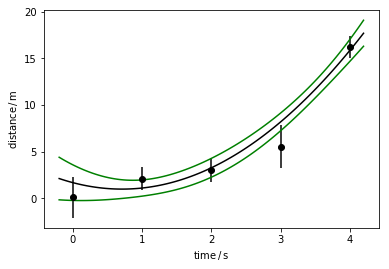

In [40]:
fit.plot(cik=1,xlabel='time',ylabel=distance)  
# cik is the coverage factor for the fit uncertainty band,
# alterately the cip parameter can be set to give a
# probability level for the band

gummy keeps track of the correlation between the fit parameters:

In [41]:
uc.gummy.correlation_matrix(fit.p)

array([[ 1.        , -0.87008433,  0.76175667],
       [-0.87008433,  1.        , -0.97186893],
       [ 0.76175667, -0.97186893,  1.        ]])

In [42]:
uc.gummy.covariance_matrix(fit.p)

array([[ 3.62156836, -3.35363548,  0.62426861],
       [-3.35363548,  4.1021575 , -0.84765818],
       [ 0.62426861, -0.84765818,  0.18544442]])

### creating correlated gummys

Use the create static method to generate a list of correlated gummys:

In [43]:
g = uc.gummy.create([1.1,2.2,3.3],u=[0.3,0.1,0.4],correlation_matrix=[[1,0,0.5],[0,1,0],[0.5,0,1]])
g

[1.10(30), 2.20(10), 3.30(40)]

In [44]:
g[0].covariance(g[2])

0.059999999999999998

Note that mathematical operations between gummys will also create correlations between the input and output gummys.

### formatting

By default in a Jupyter notebook, gummy output is rendered using HTML:

In [45]:
acceleration = fit.p[2]
acceleration

1.37(43) m/s²

But they can also be displayed using LaTeX:

In [46]:
acceleration.latex()

<IPython.core.display.Math object>

The latex() method is like a print command but rendering the output with LaTeX.  There is also a html() method.  Output can also be printed using only ASCII or unicode characters:

In [47]:
acceleration.ascii()

1.37(43) m/s**2


In [48]:
acceleration.unicode()

1.37(43) m/s²


Use the tolatex() or tohtml() methods to get a string with the LaTeX or HTML encoding for the gummy.

In [49]:
acceleration.tolatex()

'1.37(43)\\:\\mathrm{m}/\\mathrm{s}^{2}'

In [50]:
acceleration.tohtml()

'<span>1.37(43)&nbsp;m/s<sup>2</sup></span>'

It is also possible to change the default output to LaTeX:

In [51]:
uc.gummy.printer = 'latex'
acceleration

1.37(43) m/s²

or unicode:

In [52]:
uc.gummy.printer = 'unicode'
acceleration

1.37(43) m/s²

or output using only ASCII characters:

In [53]:
uc.gummy.printer = 'ascii'
acceleration

1.37(43) m/s**2

or back to HTML:

In [54]:
uc.gummy.printer = 'html'
acceleration

1.37(43) m/s²

Uncertainty budgets and fits can also be rendered using LaTeX:

In [55]:
budget = pressure.budget([side_a,side_b,force],uunit='%')
budget.latex()

<IPython.core.display.Math object>

In [56]:
budget.tolatex()

'\\begin{array}{ c c c c c c }\n\\text{Component} & \\text{Unit} & \\text{Value} & u\\,/\\,\\mathrm{\\%} & \\left\\lvert\\frac{\\partial y}{\\partial x} \\right\\rvert & s \\\\\n\\hline\n\\text{Force} & \\mathrm{N} & 0.934 & 5.9 & 27 & 0.70 \\\\\n\\text{Side B} & \\mathrm{mm} & 3.03 & 5.7 & 8.2 & 0.68 \\\\\n\\text{Side A} & \\mathrm{cm} & 1.234 & 1.9 & 20 & 0.22 \\\\\n\\hline\nP & \\mathrm{kPa} & 25.0 & 2.1 &  &  \\\\\n\\hline\nU_c \\text{ at } k = 2.0 & \\mathrm{kPa} &  & 17 &  &  \\\\\n\\end{array}'

As can the ouput of the fit from the curve fitting section:

In [57]:
fit.latex()

<IPython.core.display.Math object>

### floating point rounding errors

The gummy object has a setting to automatically include uncertainty due to floating point rounding errors:

In [58]:
uc.gummy.rounding_u = True

uc.gummy(1.23)

1.229 999 999 999 999 982(58)

In [59]:
uc.gummy(np.float32(1/3))

0.333 333 343 3(84)

In [60]:
uc.gummy(3.30000000000001) - uc.gummy(3.3)

1.021(22)e-14

The `rounding_u` option simply adds and an uncertainty proportional to the machine epsilon whenever a gummy is created with a floating point data type and then propagates this uncertainty like any other uncertainty.  This feature is experimental and perhaps can give some idea of the magnitude of the floating point errors, but is not a substitute for a full numerical error analysis.

The gummy object recognizes that integer and Faction values do not need an uncertainty component to account for rounding:

In [61]:
uc.gummy(3)

3

In [62]:
from fractions import Fraction
uc.gummy(Fraction(1,3))

1/3

In [63]:
uc.gummy(3)/uc.gummy(7)

3/7

<footer id="attribution" style="float:right; color:#999; background:#fff;">
&copy; Copyright 2019, National Research Council Canada
</footer>